In [1]:
import os
current_directory = os.getcwd()
print(f"Current Working Directory: {current_directory}")

from Tusc5ImageUtils import *
import numpy as np
from urllib.parse import urlparse
import matplotlib.pyplot as plt
import matplotlib as mpl
from skimage import exposure
mpl.rcParams['figure.dpi'] = 300
from cellpose import utils, io, plot, models, denoise
from scipy.ndimage import binary_erosion, binary_fill_holes, center_of_mass
from scipy.signal import find_peaks
import subprocess
import pandas as pd
import nd2
from skimage.measure import regionprops

Current Working Directory: d:\Lab Analysis PC\ImageAnalysis


c:\Users\Luis\anaconda3\envs\cellpose\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [9]:
### Directory Configuration ###

parent_directory = os.path.dirname(current_directory) # Parent directory
test_stacks_directory = os.path.join(parent_directory, 'Test Stacks')

model_path_dapi = os.path.join(parent_directory, 'ImageAnalysis/cellpose_models/T5_DAPI_V1')
img_path = os.path.join(test_stacks_directory, '2007R_GLUT1_647_WGA_594_0002.nd2')

In [63]:
### Image Insertion ###

f = nd2.ND2File(img_path)
z_sep = f.voxel_size().z
image = f.asarray()

DAPI_stack = to_8bit(image[:,0,:,:].copy())
eGFP_stack = to_8bit(image[:,1,:,:].copy())
WGA_stack = to_8bit(image[:,2,:,:].copy())
GLUT1_stack = to_8bit(image[:,3,:,:].copy())

mp_DAPI = max_proj(DAPI_stack)
model = models.CellposeModel(pretrained_model=model_path_dapi)
DAPI_masks, flows, styles = model.eval(mp_DAPI, diameter=None, channels=[0,0])

/var/folders/sl/syqsj8q94yn7kbv8l50mtwdw0000gn/T/ipykernel_48690/3179133809.py:3: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  f = nd2.ND2File(img_path)


# Cell Fluoresence Retrieval

In [16]:
### Directory Configuration ###
model_path_wga = os.path.join(parent_directory, 'ImageAnalysis/cellpose_models/T5_DAPI_V2')

In [131]:
import numpy as np
import pandas as pd
from skimage.measure import regionprops

def get_sq_stacks(DAPI_stack, WGA_stack, eGFP_stack, GLUT1_stack, single_mask, z_sep):
    sq_maski = square_mask(single_mask)

    # Extract bounding box around the mask
    min_row, min_col, max_row, max_col = regionprops(sq_maski.astype(int))[0].bbox

    # Extracting stacks within the bounding box
    sq_WGA_stack = WGA_stack[:, min_row:max_row, min_col:max_col]
    sq_DAPI_stack = DAPI_stack[:, min_row:max_row, min_col:max_col]
    sq_eGFP_stack = eGFP_stack[:, min_row:max_row, min_col:max_col]
    sq_GLUT1_stack = GLUT1_stack[:, min_row:max_row, min_col:max_col]

    sq_stacks = np.stack((sq_WGA_stack, sq_DAPI_stack, sq_eGFP_stack, sq_GLUT1_stack))

    return sq_stacks


def model_traces(sq_stacks, single_mask, z_sep):
    sq_WGA_stack, sq_DAPI_stack, sq_eGFP_stack, sq_GLUT1_stack = sq_stacks

    #_, _, comzi = nucleus_com(sq_DAPI_stack, single_mask)  # Gets the nucleus stack of the middle of the cell
    comzi = np.argmax(np.sum(sq_DAPI_stack, axis=(1, 2)))

    sq_WGA_slice = sq_WGA_stack[comzi]

    # 1. Run model WGA slice
    model = models.CellposeModel(gpu=True, pretrained_model=model_path_dapi)
    masks, flows, styles = model.eval(sq_WGA_slice, diameter=None, channels=[0,0])

    if len(np.unique(masks)) < 2:
        print('No mask found')

        pass

    elif len(np.unique(masks)) > 2:
        #raise Exception('More than one mask found')

    # Function to keep the largest mask
        largest_idx = np.argmax(utils.diameters(masks)[1])
        masks = extract_masks(masks, largest_idx)

    # Retrieving values in a vectorized manner
    stacks = np.array([sq_WGA_stack, sq_DAPI_stack, sq_eGFP_stack, sq_GLUT1_stack])
    masked_stacks = stacks * masks
    summed_values = np.sum(masked_stacks, axis=(-1, -2))  # Sum along the spatial dimensions

    # Store the results with corresponding channel names
    channel_names = ['WGA', 'DAPI', 'eGFP', 'GluT1']
    result = {name: value for name, value in zip(channel_names, summed_values)}

    return result

def create_dataframe(image, masks, channels=None, z_sep = z_sep):
    # Default channels if none are provided
    if channels is None:
        DAPI_channel = 0
        eGFP_channel = 1
        WGA_channel = 2
        GluT1_channel = 3

        channels = {
            'DAPI': DAPI_channel,
            'eGFP': eGFP_channel,
            'WGA': WGA_channel,
            'GluT1': GluT1_channel
        }

    # Initialize lists to store the data
    summed_values_list = []
    mask_id_list = []
    channel_list = []

    # Extract individual channel stacks
    DAPI_stack = image[:, channels['DAPI'], :, :]
    eGFP_stack = image[:, channels['eGFP'], :, :]
    WGA_stack = image[:, channels['WGA'], :, :]
    GLUT1_stack = image[:, channels['GluT1'], :, :]

    # Iterate through each unique mask in masks
    for mask_id in np.delete(np.unique(DAPI_masks),0)-1:
        single_mask = extract_masks(masks, mask_id)
        
        # Get square stacks around the mask
        sq_stacks = get_sq_stacks(DAPI_stack, WGA_stack, eGFP_stack, GLUT1_stack, single_mask, z_sep= z_sep)  # Example z_sep

        # Get the model traces
        trace_results = model_traces(sq_stacks, single_mask, z_sep=z_sep)  # Example z_sep

        # Append data to lists
        for channel_name, summed_values in trace_results.items():
            summed_values_list.append(summed_values.tolist())
            mask_id_list.append(mask_id)
            channel_list.append(channel_name)

    # Create a DataFrame from the collected data
    data = {
        'Y_vals': summed_values_list,
        'mask_id': mask_id_list,
        'Stain': channel_list
    }
    df = pd.DataFrame(data)

    return df

# Example usage:
# Assuming 'image' and 'masks' are already defined as numpy arrays and model_path_dapi is set
df = create_dataframe(image, DAPI_masks)

def organize_data(trace_results):
    
    summed_values_list = []
    mask_id_list = []
    channel_list = []

    for channel_name, summed_values in trace_results.items():
            summed_values_list.append(summed_values.tolist())
            mask_id_list.append(mask_id)
            channel_list.append(channel_name)

    # Create a DataFrame from the collected data
    data = {
        'Y_vals': summed_values_list,
        'mask_id': mask_id_list,
        'Stain': channel_list
    }
    df = pd.DataFrame(data)

    return df

No mask found
No mask found


KeyboardInterrupt: 

In [134]:
script = f'POSIX path of (choose folder default location "{current_directory}")'
selected_folder = subprocess.check_output(['osascript', '-e', script]).decode('utf-8').strip()

# Get the list of all .nd2 files in the selected folder
nd2_files = [f for f in os.listdir(selected_folder) if f.endswith('.nd2')]

all_data = pd.DataFrame()

unid_counter = 0

# Process each .nd2 file
for nd2_file in nd2_files:
    print(f'Processing {nd2_file}')
    nd2_path = os.path.join(selected_folder, nd2_file)

    f = nd2.ND2File(nd2_path)
    z_sep = f.voxel_size().z
    image = f.asarray()

    DAPI_stack = to_8bit(image[:,0,:,:].copy())
    mp_DAPI = max_proj(DAPI_stack)
    model = models.CellposeModel(pretrained_model=model_path_dapi)
    DAPI_masks, flows, styles = model.eval(mp_DAPI, diameter=None, channels=[0,0])

    df = create_dataframe(image, DAPI_masks)
    
    # Adding 'X_vals' to the dataframe
    # Adding file_name, DJID, and Eye info to the  dataframe
    djid, eye, file_base = extract_information(nd2_file)

    nested_array = np.array(range(image.shape[0]))* f.voxel_size().z
    df['X_vals'] = [nested_array for i in range(len(df))]
    df['file_name'] = file_base
    df['DJID'] = djid
    df['Eye'] = eye

    # Assign a unique cell_unid for each unique mask_id
    unique_mask_ids = df['mask_id'].unique()
    mask_id_to_unid = {mask_id: unid_counter + i for i, mask_id in enumerate(unique_mask_ids)}
    df['cell_unid'] = df['mask_id'].map(mask_id_to_unid)
    unid_counter += len(unique_mask_ids)

    # Concatenate the current df with the all_data dataframe
    all_data = pd.concat([all_data, df], ignore_index=True)

Processing 2006L_GLUT1_647_WGA_594_0003.nd2


/var/folders/sl/syqsj8q94yn7kbv8l50mtwdw0000gn/T/ipykernel_48690/2568392365.py:16: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  f = nd2.ND2File(nd2_path)


No mask found
No mask found
No mask found
No mask found
No mask found
No mask found
No mask found


No mask found
No mask found
No mask found
No mask found
No mask found
No mask found
No mask found
No mask found
No mask found
No mask found
No mask found
No mask found
No mask found
No mask found
No mask found
No mask found
Processing 2006R_GLUT1_647_WGA_594_0002.nd2


/var/folders/sl/syqsj8q94yn7kbv8l50mtwdw0000gn/T/ipykernel_48690/2568392365.py:16: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  f = nd2.ND2File(nd2_path)


No mask found
No mask found
No mask found
No mask found
No mask found
No mask found
No mask found
No mask found
No mask found
No mask found
No mask found
No mask found


In [13]:
parent_directory = os.path.dirname(current_directory) # Parent directory
test_stacks_dir = os.path.join(parent_directory, 'Test Stacks')

In [11]:
test_stacks_dir
os.path.normpath('D:\Lab Analysis PC\Test Stacks')

'D:\\Lab Analysis PC\\Test Stacks'

In [18]:
#script = f'POSIX path of (choose folder default location "{current_directory}")'
#selected_folder = subprocess.check_output(['osascript', '-e', script]).decode('utf-8').strip()
# nd2_files = [f for f in os.listdir(selected_folder) if f.endswith('.nd2')]
selected_folder = os.path.normpath('D:\Lab Analysis PC\Test Stacks')
nd2_files = [f for f in os.listdir(os.path.normpath('D:\Lab Analysis PC\Test Stacks')) if f.endswith('.nd2')]

### Model Paths ###
model_path_dapi = os.path.join(parent_directory, 'ImageAnalysis/cellpose_models/T5_DAPI_V2')
model_path_wga = os.path.join(parent_directory, 'ImageAnalysis/cellpose_models/T5_WGA_V2')

all_data = pd.DataFrame()
unid_counter = 0

for nd2_file in nd2_files:

    # 1) Download Image Data
    print(f'Processing {nd2_file}')
    nd2_path = os.path.join(selected_folder, nd2_file)

    f = nd2.ND2File(nd2_path)
    z_sep = f.voxel_size().z
    image = f.asarray()

    # 2) Initial segmentation of DAPI max projection
    DAPI_stack = to_8bit(image[:,0,:,:].copy())
    mp_DAPI = max_proj(DAPI_stack)

    # 3) Deblur and Segment DAPI max projection
    deblur_model = denoise.CellposeDenoiseModel(gpu=True, model_type = model_path_dapi, restore_type="deblur_cyto3")
    DAPI_masks, flows, styles, image_deblurred = deblur_model.eval(auto_brightness_contrast(mp_DAPI), diameter=90, channels=[0,0])

    image_deblurred = image_deblurred[:,:,0] # resulting image has one channel, but it still needs to be indexed 

    '''
    Indiviudal Cell
    '''

    # 5) Segmentation of WGA channel

    mask_idxs = np.delete(np.unique(DAPI_masks), 0) - 1

    for mask_id in mask_idxs:
        single_mask = extract_masks(DAPI_masks, mask_id)
        diam = get_mask_diameter(single_mask)
        expansion = 50

        sq_stacks = get_sq_stacks(image, single_mask)
        
        # Running the model of the expanded squares
        expanded_sq_WGA = extract_square_proj_expand(image, single_mask, expansion)

        model = models.CellposeModel(gpu = True, pretrained_model = model_path_wga)
        expanded_mask, flows, styles = model.eval(expanded_sq_WGA, diameter=diam, channels=[0,0])

        # Removing 0-pixel boundary and finding the largest mask in the array
        WGA_mask = remove_boundary(expanded_mask, expansion)

        #if len(utils.diameters(WGA_mask)[1]) == 0:
        #    print('No mask found.')
        #    continue

        if len(np.unique(WGA_mask)) == 1:
            print('No mask found.')
            continue

        largest_idx = np.argmax(utils.diameters(WGA_mask)[1])
        WGA_mask = extract_masks(WGA_mask, largest_idx)

        # Z-axis profile
        trace_results = get_traces(sq_stacks, WGA_mask)

        '''
        Organizing data
        '''
        
        # 6) Converting trace results into a pd dataframe
        dataframe = organize_data(trace_results, mask_id)

        # 7) Adding file information
        djid, eye, file_base = extract_information(nd2_file)

        nested_array = np.array(range(image.shape[0]))* f.voxel_size().z
        dataframe['X_vals'] = [nested_array for i in range(len(dataframe))]
        dataframe['file_name'] = file_base
        dataframe['DJID'] = djid
        dataframe['Eye'] = eye

        # 8) cell_unid information
        unique_mask_ids = dataframe['mask_id'].unique()
        mask_id_to_unid = {mask_id: unid_counter + i for i, mask_id in enumerate(unique_mask_ids)}
        dataframe['unid'] = dataframe['mask_id'].map(mask_id_to_unid)
        unid_counter += len(unique_mask_ids)

        # 9) Concatenation with existing data
        all_data = pd.concat([all_data, dataframe], ignore_index=True)

Processing 2007R_GLUT1_647_WGA_594_0002.nd2


C:\Users\Luis\AppData\Local\Temp\ipykernel_7764\1243920464.py:20: UserWarning: ND2File file not closed before garbage collection. Please use `with ND2File(...):` context or call `.close()`.
  f = nd2.ND2File(nd2_path)


No mask found.
No mask found.
No mask found.
No mask found.
No mask found.
No mask found.


d:\Lab Analysis PC\ImageAnalysis\Tusc5ImageUtils.py:595: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  single_cell['Stain'] = single_cell['Stain'].apply(lambda x: 'GluT1' if x == 'GluT1' else x)


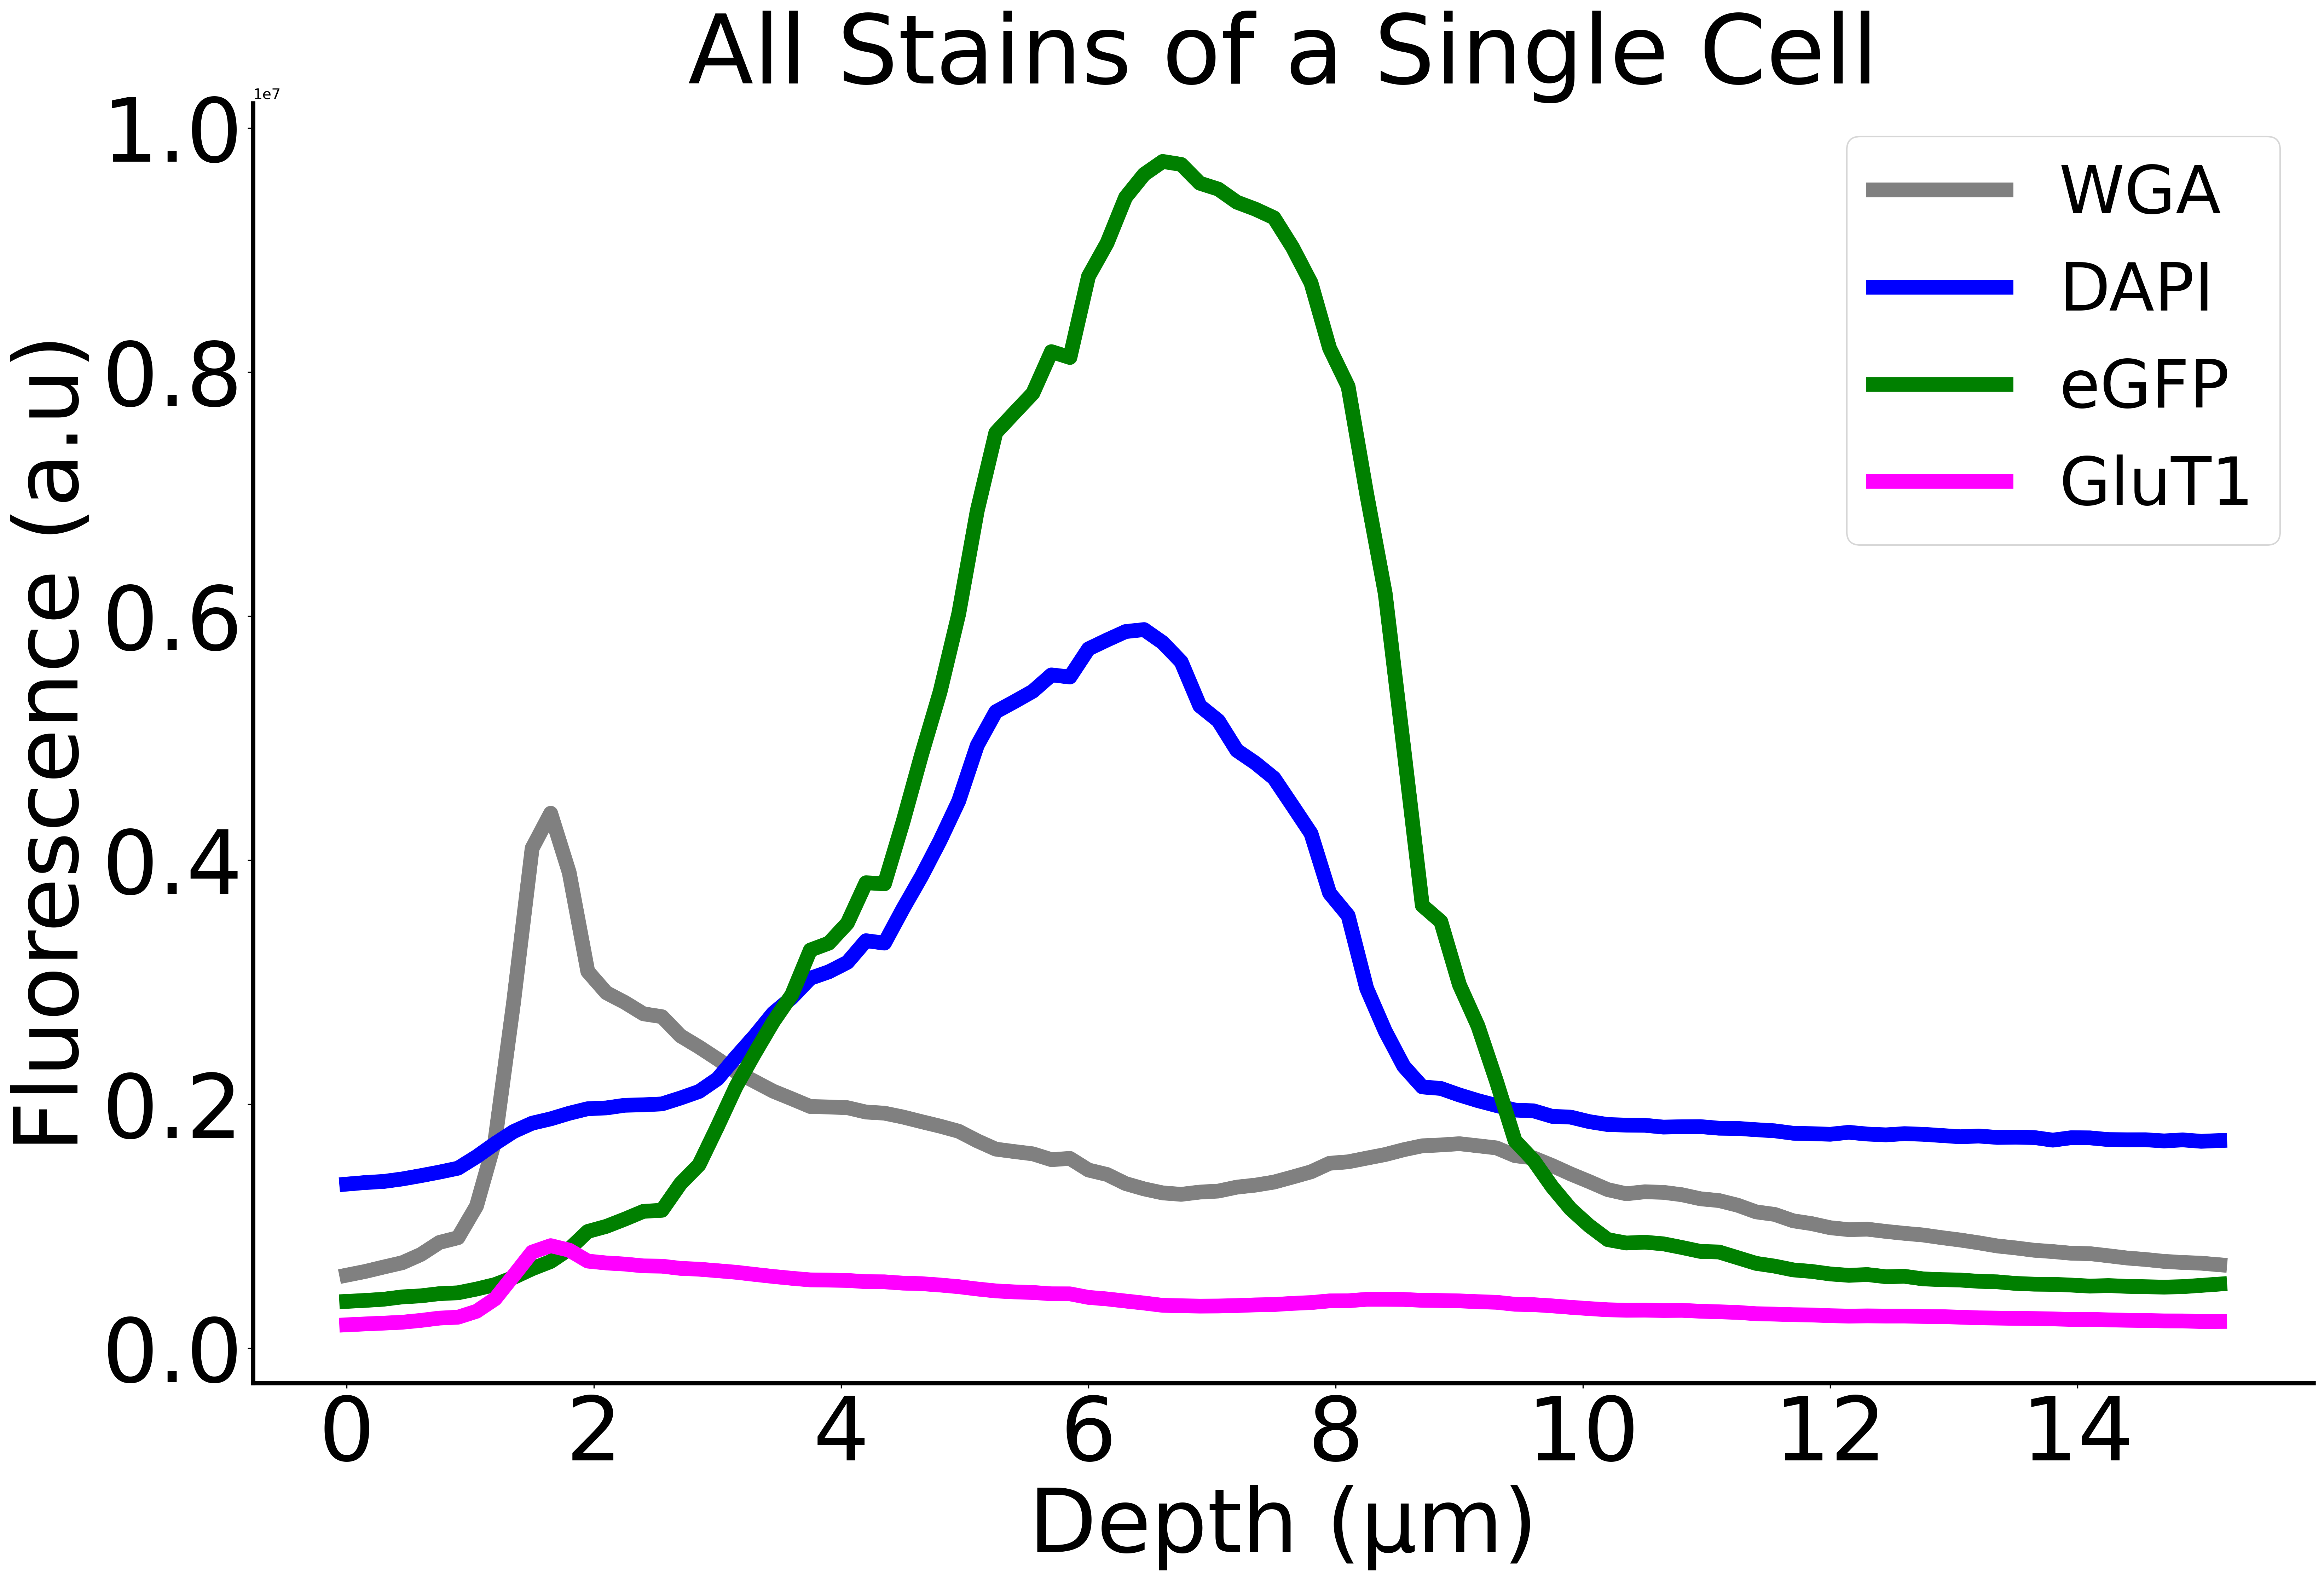

In [26]:
from scipy.signal import find_peaks

single_cell = all_data.query('unid == 67')
plot_single_cell(single_cell)